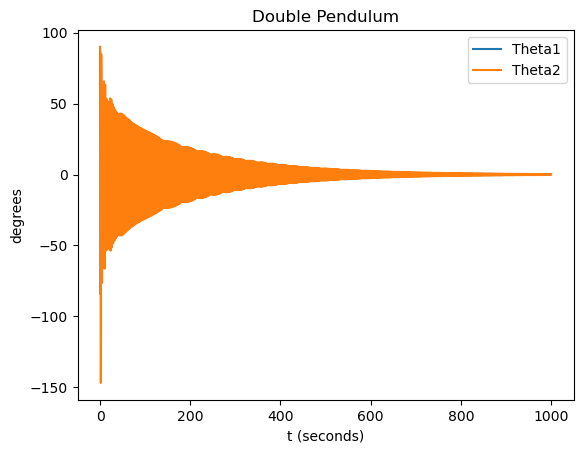

In [1]:
#Intial calculation functions
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score


# Generate the dataset using the provided differential equation solver
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 * 
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 * 
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return array([ftheta1, fomega1, ftheta2, fomega2], float)

# Time parameters
a = 0.0
b = 1000
N = 3000
h = (b - a) / N

# Arrays to store results
tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

# Initial conditions
q = np.array([pi / 2, 0, pi / 2, 0], float)

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi  # Convert to degrees
    theta2_points[i] = q[2] * 180 / pi

    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Plot the data
plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()

Epoch 1, Loss: 0.0015294889453798532
Epoch 2, Loss: 0.001998342340812087
Epoch 3, Loss: 0.002452649176120758
Epoch 4, Loss: 0.0016693341312929988
Epoch 5, Loss: 0.0011559562990441918
Epoch 6, Loss: 0.0018278983188793063
Epoch 7, Loss: 0.002225665608420968
Epoch 8, Loss: 0.0015504930634051561
Epoch 9, Loss: 0.0015660511562600732
Epoch 10, Loss: 0.0016741497674956918
Epoch 11, Loss: 0.0022180795203894377
Epoch 12, Loss: 0.002551764715462923
Epoch 13, Loss: 0.0017940776888281107
Epoch 14, Loss: 0.0011311053531244397
Epoch 15, Loss: 0.001267958665266633
Epoch 16, Loss: 0.0007888749241828918
Epoch 17, Loss: 0.001687271404080093
Epoch 18, Loss: 0.0011634968686848879
Epoch 19, Loss: 0.0011934126960113645
Epoch 20, Loss: 0.0017824253300204873
Epoch 21, Loss: 0.0017217006534337997
Epoch 22, Loss: 0.0013298961566761136
Epoch 23, Loss: 0.0005596015835180879
Epoch 24, Loss: 0.000679036311339587
Epoch 25, Loss: 0.0008525688899680972
Epoch 26, Loss: 0.000718923460226506
Epoch 27, Loss: 2.19466583075

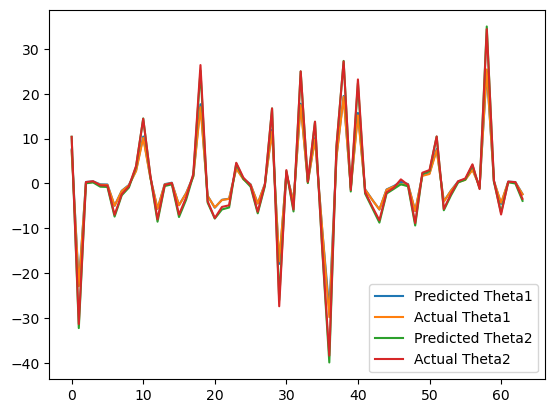

In [2]:
#BI DIRECTIONAL LSTM


# Combine the data
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

# Load the data
data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Prepare the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Bidirectional LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(BiLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

input_size = 2  # number of features
hidden_layer_size = 100
output_size = 2  # predicting two angles

model = BiLSTMModel(input_size, hidden_layer_size, output_size)

# Access and adjust the weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)  # Xavier initialization
    elif 'bias' in name:
        nn.init.zeros_(param)  # Zero initialization

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, num_epochs):
    for epoch in range(num_epochs):
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

NUM_EPOCHS = 100
train_model(model, train_loader, NUM_EPOCHS)

# Evaluate the model with RMSE
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for sequences, targets in test_loader:
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test RMSE: {avg_test_loss}')

evaluate_model(model, test_loader)

# Make predictions
model.eval()
with torch.no_grad():
    for sequences, targets in test_loader:
        y_pred = model(sequences)
        break  # Just predicting on the first batch for demonstration

# Convert predictions back to original scale
y_pred_original = scaler.inverse_transform(y_pred.numpy())
targets_original = scaler.inverse_transform(targets.numpy())

plt.plot(y_pred_original[:, 0], label='Predicted Theta1')
plt.plot(targets_original[:, 0], label='Actual Theta1')
plt.plot(y_pred_original[:, 1], label='Predicted Theta2')
plt.plot(targets_original[:, 1], label='Actual Theta2')
plt.legend()
plt.show()

Epoch 1, Loss: 0.0012613404542207718
Epoch 2, Loss: 0.0006028975476510823
Epoch 3, Loss: 7.777387509122491e-05
Epoch 4, Loss: 1.0346297131036408e-05
Epoch 5, Loss: 2.7202524506719783e-05
Epoch 6, Loss: 2.365836189710535e-05
Epoch 7, Loss: 1.9698420146596618e-05
Epoch 8, Loss: 1.3329244211490732e-05
Epoch 9, Loss: 1.6367204807465896e-05
Epoch 10, Loss: 2.631374627526384e-05
Epoch 11, Loss: 2.8061342163709924e-05
Epoch 12, Loss: 2.0217148630763404e-05
Epoch 13, Loss: 5.7793158703134395e-06
Epoch 14, Loss: 2.531048266973812e-05
Epoch 15, Loss: 2.221030808868818e-05
Epoch 16, Loss: 3.973388811573386e-05
Epoch 17, Loss: 1.6123560271807946e-05
Epoch 18, Loss: 3.851284782285802e-05
Epoch 19, Loss: 1.7146066966233775e-05
Epoch 20, Loss: 1.0468930668139365e-05
Epoch 21, Loss: 1.0449062756379135e-05
Epoch 22, Loss: 1.1263110536674503e-05
Epoch 23, Loss: 2.5617138817324303e-05
Epoch 24, Loss: 5.638109996652929e-06
Epoch 25, Loss: 8.305523806484416e-06
Epoch 26, Loss: 3.358493631822057e-05
Epoch 2

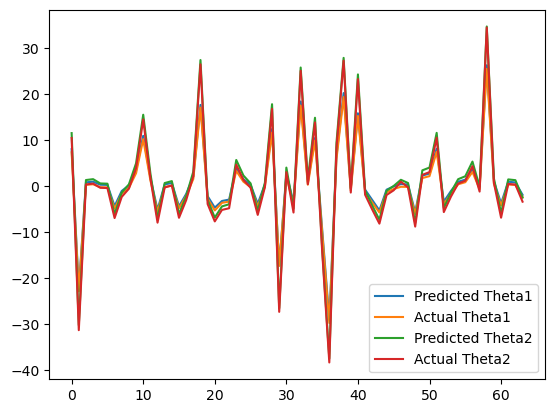

In [3]:
#BI DIRECTIONAL RNN (general)

# Combine the data
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

# Load the data
data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Prepare the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Bidirectional RNN model
class BiRNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(BiRNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_time_step = rnn_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

input_size = 2  # number of features
hidden_layer_size = 100
output_size = 2  # predicting two angles

model = BiRNNModel(input_size, hidden_layer_size, output_size)

# Access and adjust the weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)  # Xavier initialization
    elif 'bias' in name:
        nn.init.zeros_(param)  # Zero initialization

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, num_epochs):
    for epoch in range(num_epochs):
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

NUM_EPOCHS = 100
train_model(model, train_loader, NUM_EPOCHS)

# Evaluate the model with RMSE
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for sequences, targets in test_loader:
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test RMSE: {avg_test_loss}')

evaluate_model(model, test_loader)

# Make predictions
model.eval()
with torch.no_grad():
    for sequences, targets in test_loader:
        y_pred = model(sequences)
        break  # Just predicting on the first batch for demonstration

# Convert predictions back to original scale
y_pred_original = scaler.inverse_transform(y_pred.numpy())
targets_original = scaler.inverse_transform(targets.numpy())

plt.plot(y_pred_original[:, 0], label='Predicted Theta1')
plt.plot(targets_original[:, 0], label='Actual Theta1')
plt.plot(y_pred_original[:, 1], label='Predicted Theta2')
plt.plot(targets_original[:, 1], label='Actual Theta2')
plt.legend()
plt.show()